In [61]:
import numpy as np
import matplotlib.pyplot as plt
import thomson
import astropy.units as u
from astropy.constants import m_e, m_p, k_B as kB
from scipy.special import wofz
from scipy.constants import epsilon_0 as eps0, e


default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']




These functions allow us to generate arrays corresponding to Maxwellians with different temperatures and drift velocities.

In [62]:
def maxwellian_e(v, T, v_d):
    v_unitless = v
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K)
    exp_term = -(v_unitless - v_d) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def maxwellian_H(v, T, v_d):
    v_unitless = v
    T_K = T * 11605
    vth = np.sqrt(2 * 8.2544e3 * T_K)
    exp_term = -(v_unitless - v_d) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

Validate thermal velocity function:

In [63]:
Te = 100
v_d = 1e7
ve = np.linspace(-5e7, 5e7, 1000)
fe = maxwellian_e(ve, Te, v_d=v_d)


vth_m = np.sqrt(2 * Te * u.eV / m_e).to(u.m / u.s)
vth_nm = thomson.vth_nonmaxwellian(fe, ve) * u.m / u.s

print(f"Maxwellian vth: {vth_m}")
print(f"Non-Maxwellian vth: {vth_nm}")


Maxwellian vth: 5930969.584768013 m / s
Non-Maxwellian vth: 5931026.555327504 m / s


Validate calculation of susceptibility function:

Define derivative of plasma dispersion function

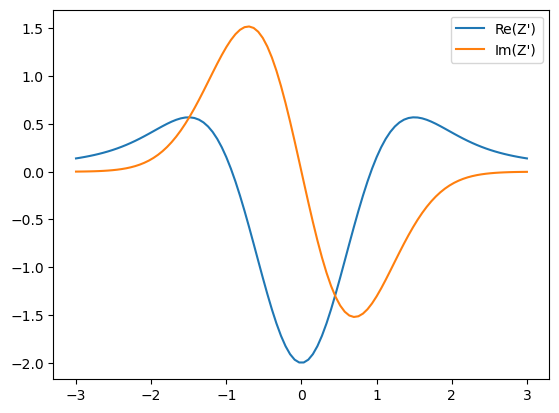

In [64]:
def Zprime(z):
    Z = np.sqrt(np.pi) * 1.j * wofz(z)
    return -2 * (1 + z*Z)

z = np.linspace(-3, 3, 100)
plt.plot(z, Zprime(z).real, label = "Re(Z')")
plt.plot(z, Zprime(z).imag, label = "Im(Z')")
plt.legend()

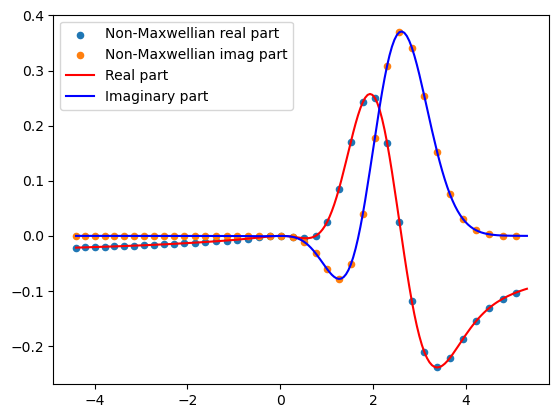

In [65]:
w = 5.71e14

probe_wavelength = 532*1e-9
epw_wavelengths = np.linspace(probe_wavelength-50, probe_wavelength+50, 200) * 1e-9
k = (1 / epw_wavelengths - 1/probe_wavelength)
ne = 4e24

vph = w/k
uph = vph / vth_m.value

lambda_D = np.sqrt(eps0 * Te * e / (ne * e**2))
alpha = 1/(k * lambda_D * u.m)

chi_m = -alpha**2/2 * Zprime((vph - v_d) / vth_m.value)

chi_nm = thomson.chi_lite(
    k = k,
    w = w,
    f_k = fe,
    v_k = ve,
    n = ne,
    z = 1,
    mass = m_e.value
)

vph = w/k
uph = vph / vth_m.value

plt.scatter(uph[::5], chi_nm.real[::5], color = default_colors[0], s = 20, label = "Non-Maxwellian real part")
plt.scatter(uph[::5], chi_nm.imag[::5], color = default_colors[1], s = 20, label = "Non-Maxwellian imag part")

plt.plot(uph, chi_m.real, color = 'r', label = "Real part")
plt.plot(uph, chi_m.imag, color = 'b', label = "Imaginary part")
plt.legend()


Validate spectral density

In [66]:
def maxwellian_e(v, T, v_d):
    v_unitless = v
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K)
    exp_term = -(v_unitless - v_d) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def maxwellian_D(v, T, v_d):
    v_unitless = v
    T_K = T * 11605
    vth = np.sqrt(2 * 8.2544e3 / 2.014 * T_K)
    exp_term = -(v_unitless - v_d) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def maxwellian_C(v, T, v_d):
    v_unitless = v
    T_K = T * 11605
    vth = np.sqrt(2 * 8.2544e3 / 12 * T_K)
    exp_term = -(v_unitless - v_d) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

Now we define the electron and ion distributions. Note that everything is dimensionless now, it's more convenient to put the units on in the function call due to how astropy handles units.

In [137]:
ve = np.linspace(-5e7, 5e7, 1000)
vi = np.linspace(-1e6, 1e6, 2000)

Te = 100
TD = 200
TC = 400

ue = 0
uD = -2e5
uC = 3e5

n = 4e18

fe = maxwellian_e(ve, Te, ue)
fD = maxwellian_D(vi, TD, uD)
fC = maxwellian_C(vi, TC, uC)

Text(0.5, 0, 'v [m/s]')

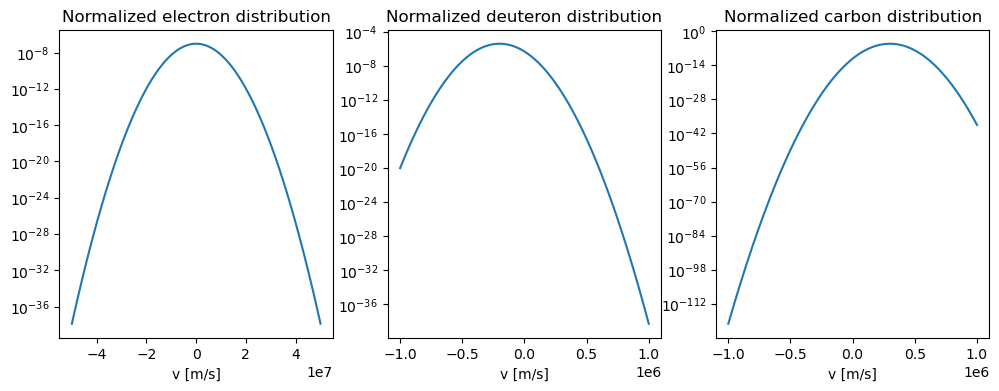

In [138]:
fig, ax = plt.subplots(ncols = 3, figsize = (12, 4))
ax[0].semilogy(ve, fe)
ax[0].set_title("Normalized electron distribution")
ax[0].set_xlabel("v [m/s]")

ax[1].semilogy(vi, fD)
ax[1].set_title("Normalized deuteron distribution")
ax[1].set_xlabel("v [m/s]")

ax[2].semilogy(vi, fC)
ax[2].set_title("Normalized carbon distribution")
ax[2].set_xlabel("v [m/s]")

Define the Thomson parameters:

In [139]:
probe_wavelength = 532
epw_wavelengths = np.linspace(probe_wavelength-30, probe_wavelength+30, 200)
iaw_wavelengths = np.linspace(probe_wavelength-2, probe_wavelength+2, 200)

theta = 63 * np.pi/180

probe_vec = np.array([0, np.sin(theta), np.cos(theta)])
scatter_vec = np.array([0, np.sin(theta), -np.cos(theta)])
k_vec = scatter_vec - probe_vec
k_vec = k_vec / np.linalg.norm(k_vec)

notch = np.array([probe_wavelength-10, probe_wavelength+10])

In [140]:
wofz(1)

(0.36787944117144233+0.6071577058413937j)

2.507404980413497
2.5081073438160457


(90.0, 110.0)

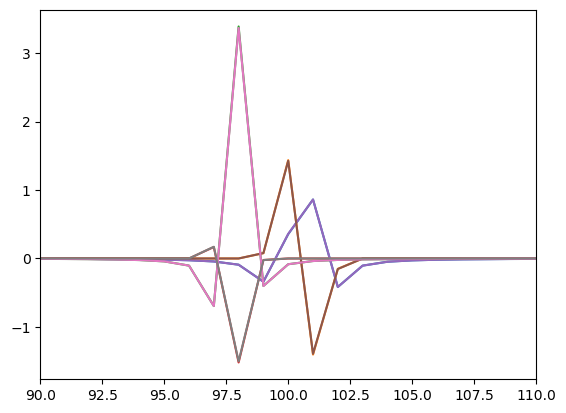

In [141]:
alpha, epw_Skw = thomson.spectral_density(
    wavelengths = epw_wavelengths * u.nm,
    probe_wavelength = probe_wavelength * u.nm,
    n = n * u.cm**(-3),
    fe_k = np.array([fe]) * u.s / u.m,
    ve_k = np.array([ve]) * u.m / u.s,
    fi_k = np.array([fD, fC]) * u.s / u.m,
    vi_k = np.array([vi, vi]) * u.m / u.s,
    ifract = [0.9, 0.1],
    ions = ['D 1+', "C-12 6+"],
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
    notch = notch * u.nm
)
print(alpha)

alpha, epw_Skw_maxwellian = thomson.spectral_density_maxwellian(
    wavelengths = epw_wavelengths * u.nm,
    probe_wavelength = probe_wavelength * u.nm,
    n = n * u.cm**(-3),
    T_e = Te * u.eV,
    T_i = np.array([TD, TC])*u.eV,
    ifract = [0.9, 0.1],
    ions = ['D 1+', "C-12 6+"],
    ion_vel=[k_vec * uD, k_vec * uC] * u.m / u.s,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
    notch = notch * u.nm
    
)
print(alpha)
plt.xlim(90, 110)
#plt.ylim(-2, 2)

In [142]:
3.53941011911948 / alpha / (np.sqrt(2))

0.997860359844802

(0.0, 2e-14)

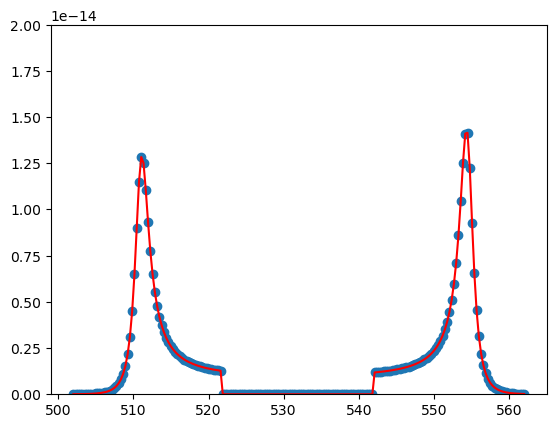

In [145]:
plt.scatter(epw_wavelengths, epw_Skw, label='')

plt.plot(epw_wavelengths, epw_Skw_maxwellian, 'r')
plt.ylim(0, 2e-14)

2.510037709273408
2.51006481184766


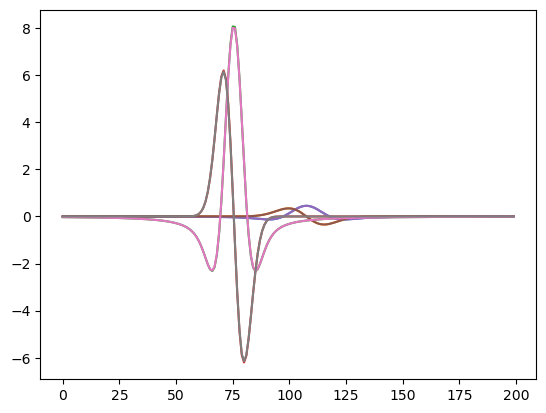

In [117]:
alpha, iaw_Skw = thomson.spectral_density(
    wavelengths = iaw_wavelengths * u.nm,
    probe_wavelength = probe_wavelength * u.nm,
    n = n * u.cm**(-3),
    fe_k = np.array([fe]) * u.s / u.m,
    ve_k = np.array([ve]) * u.m / u.s,
    fi_k = np.array([fD, fC]) * u.s / u.m,
    vi_k = np.array([vi, vi]) * u.m / u.s,
    ifract = [0.5, 0.5],
    ions = ['D 1+', "C-12 6+"],
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)
print(alpha)

alpha, iaw_Skw_maxwellian = thomson.spectral_density_maxwellian(
    wavelengths = iaw_wavelengths * u.nm,
    probe_wavelength = probe_wavelength * u.nm,
    n = n * u.cm**(-3),
    T_e = Te * u.eV,
    T_i = np.array([TD, TC])*u.eV,
    ifract = [0.5, 0.5],
    ions = ['D 1+', "C-12 6+"],
    ion_vel=[k_vec * uD, k_vec * uC] * u.m / u.s,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)
print(alpha)

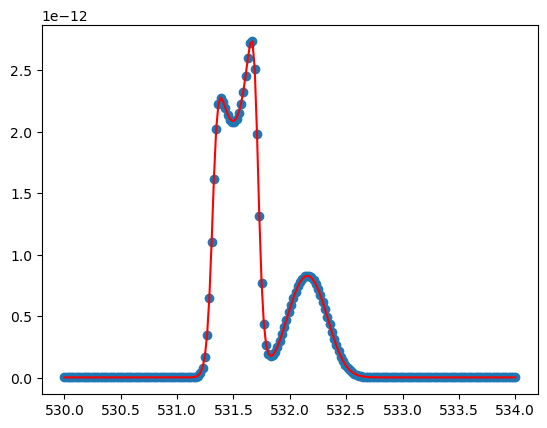

In [118]:
plt.scatter(iaw_wavelengths, iaw_Skw, label='')

plt.plot(iaw_wavelengths, iaw_Skw_maxwellian, label='', color = 'r')
#plt.ylim(0, 2e-14)